# Our installs and imports

In [0]:
!pip install catboost
!pip install shap

In [0]:
# Access our Google Drive
from google.colab import drive

# Machine Learning
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.preprocessing import LabelEncoder

# ML Model Insights
import shap

# Date processing
import pandas as pd
import numpy as np

# Std library
import re
import json
import requests
from datetime import datetime

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bar
from tqdm import tqdm_notebook

# Serializing LabelEncoder
import pickle

# Mounting our drive

In [0]:
drive.mount('/content/drive', force_remount=True)

DRIVE_PATH = '/content/drive/Reliability score ML'

Mounted at /content/drive


# Reading in all our data

In [0]:
headers = open(f'{DRIVE_PATH}/headers', 'r').read().strip()

df = pd.read_csv(f'{DRIVE_PATH}/test_set_bigger.csv', header=None)
df.columns = headers.split(',')

# Feature extraction: functions to apply and pandas one-liners

Currently extracting:

* `STATION_ARR` -- the station (iRail ID) where the train originally departs
* `STATION_DEP` -- the station (iRail ID) where train has to arrive
* `dotw` -- day of the week (0: Monday - 6: Sunday)
* `weekend` -- whether dotw is larger than 4
* `month` -- from 1 (Jan) to 12 (Dec)
* `seconds_since_midnight` -- number of seconds already passed in current day
* `expected_time_station` -- number of seconds between `PLAN_DEP` and `PLAN_ARR`
* `LNG_CUR` -- Longitude of the current station
* `LAT_CUR` -- Latitude of the current station
* `STOP_CUR` -- the current station (iRail IDI)
* `train_type` -- IC, L, S, ... (stripped from `RELATION`)
* `LINE_ID` -- Concatenation of `train_type` and `TRAIN_NO`
* `STOP_ARR` -- Expected stop time of the arrival station, according to iRail's `stations.csv`
* `STOP_DEP` -- Expected stop time of the departure station, according to iRail's `stations.csv`
* `LINE` -- Concatenation of `STATION_ARR` and `STATION_DEP`

In [0]:
def extract_dotw(x):
  return x.weekday()

def extract_month(x):
  return x.month

def extract_seconds_since_midnight(x):
  x_midnight = x.replace(hour=0, minute=0, second=0, microsecond=0)
  return (x - x_midnight).total_seconds()

def extract_expected_time_in_station(x):
  return (x['PLAN_DEP'] - x['PLAN_ARR']).total_seconds()

def stationToURI(station, station_uris):
    try:
        return station_uris[station.lower()]
    except KeyError:
        return np.NaN

def split_stations(direction, station_uris, _type='arrival'):
  if pd.isnull(direction):
    return np.NaN
  
  REGEX = r': (.*) (?:->) (.*)'
  vehicle_arrival_station = re.search(REGEX, direction).group(1)
  vehicle_departure_station = re.search(REGEX, direction).group(2)
  
  if _type == 'arrival':
    return stationToURI(vehicle_arrival_station, station_uris)
  else:
    return stationToURI(vehicle_departure_station, station_uris)
  
  
def get_line_number(vehicle):
    # Verwachte input: "IC1515"
  
    pattern = re.compile("^([A-Z]+)[0-9]+$")
    vehicle_type = pattern.match(vehicle).group(1)
    pattern = re.compile("^[A-Z]+([0-9]+)$")
    vehicle_nr = int(pattern.match(vehicle).group(1))
    line_nr = 0
    if vehicle_type == 'IC':
        line_nr = str(int(100 * np.floor(vehicle_nr / 100)))
    elif vehicle_type == 'L':
        line_nr = str(int(50 * np.floor(vehicle_nr / 50)))
    elif vehicle_type == 'S':
        line_nr = str(int(50 * np.floor(vehicle_nr / 50)))
    else:
        line_nr = 'P'
    
    return vehicle_nr, line_nr
  
def get_train_type(x):
  return x.split(' ')[0]

# Station Features
with open(f'{DRIVE_PATH}/station_uris_extended.json', 'r') as f:
    station_uris = json.load(f)
    df['STATION_ARR'] = df['RELATION_DIRECTION'].apply(lambda x: split_stations(x, station_uris, _type='arrival'))
    df['STATION_DEP'] = df['RELATION_DIRECTION'].apply(lambda x: split_stations(x, station_uris, _type='departure'))
    df['STATION_CUR'] = df['PTCAR_LG_NM_NL'].apply(lambda x: stationToURI(x, station_uris))
    df['LINE'] = df['STATION_ARR'] + '_' + df['STATION_DEP']

# # Parsing the datetimes
df['REAL_ARR'] = df['REAL_DATE_ARR'] + ' ' + df['REAL_TIME_ARR']
df['REAL_DEP'] = df['REAL_DATE_DEP'] + ' ' + df['REAL_TIME_DEP']
df['PLAN_ARR'] = df['PLANNED_DATE_ARR'] + ' ' + df['PLANNED_TIME_ARR']
df['PLAN_DEP'] = df['PLANNED_DATE_DEP'] + ' ' + df['PLANNED_TIME_DEP']
df['REAL_ARR'] = pd.to_datetime(df['REAL_ARR'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['REAL_DEP'] = pd.to_datetime(df['REAL_DEP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['PLAN_ARR'] = pd.to_datetime(df['PLAN_ARR'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df['PLAN_DEP'] = pd.to_datetime(df['PLAN_DEP'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Re-calculating the delays
df['DELAY_ARR'] = df['REAL_ARR'].subtract(df['PLAN_ARR']).dt.total_seconds()
df['DELAY_DEP'] = df['REAL_DEP'].subtract(df['PLAN_DEP']).dt.total_seconds()

# Time Features
df['dotw'] = df['REAL_ARR'].apply(extract_dotw)
df['weekend'] = df['dotw'] > 4
df['month'] = df['REAL_ARR'].apply(extract_month)
df['seconds_since_midnight'] = df['REAL_ARR'].apply(extract_seconds_since_midnight)
df['expected_time_station'] = df[['PLAN_DEP', 'PLAN_ARR']].apply(extract_expected_time_in_station, axis=1)

# Train features
df['train_type'] = df['RELATION'].apply(get_train_type)
df['LINE_ID'] = df['train_type'].astype(str) + df['TRAIN_NO'].astype(str)

df.sample(5)

,DATDEP,TRAIN_NO,RELATION,TRAIN_SERV,PTCAR_NO,LINE_NO_DEP,REAL_TIME_ARR,REAL_TIME_DEP,PLANNED_TIME_ARR,PLANNED_TIME_DEP,DELAY_ARR,DELAY_DEP,RELATION_DIRECTION,PTCAR_LG_NM_NL,LINE_NO_ARR,PLANNED_DATE_ARR,PLANNED_DATE_DEP,REAL_DATE_ARR,REAL_DATE_DEP,STATION_ARR,STATION_DEP,STATION_CUR,LINE,REAL_ARR,REAL_DEP,PLAN_ARR,PLAN_DEP,dotw,weekend,month,seconds_since_midnight,expected_time_station,train_type,LINE_ID
356072,2019-06-18,2138,IC 16-1,SNCB/NMBS,617,162,16:38:57,16:41:41,16:40:00,16:41:00,-63.0,41.0,IC 16-1: LUXEMBOURG -> BRUSSEL-ZUID,ROCHEFORT-JEMELLE,162,2019-06-18,2019-06-18,2019-06-18,2019-06-18,http://irail.be/stations/NMBS/008200100,http://irail.be/stations/NMBS/008814001,http://irail.be/stations/NMBS/008864006,http://irail.be/stations/NMBS/008200100_http:/...,2019-06-18 16:38:57,2019-06-18 16:41:41,2019-06-18 16:40:00,2019-06-18 16:41:00,1.0,False,6.0,59937.0,60.0,IC,IC2138
173620,2019-06-15,3830,IC 25,SNCB/NMBS,427,75A,10:33:46,10:33:46,10:35:00,10:35:00,-74.0,-74.0,IC 25: LIERS -> MOESKROEN,FROYENNES,94,2019-06-15,2019-06-15,2019-06-15,2019-06-15,http://irail.be/stations/NMBS/008841673,http://irail.be/stations/NMBS/008885704,http://irail.be/stations/NMBS/008885068,http://irail.be/stations/NMBS/008841673_http:/...,2019-06-15 10:33:46,2019-06-15 10:33:46,2019-06-15 10:35:00,2019-06-15 10:35:00,5.0,True,6.0,38026.0,0.0,IC,IC3830
950324,2019-06-28,9310,THAL,THI-FACT,866,25,07:39:25,07:39:25,07:38:00,07:38:00,85.0,85.0,THAL: AMSTERDAM CENTRAAL -> PARIS-NORD,MORTSEL-OUDE GOD,25,2019-06-28,2019-06-28,2019-06-28,2019-06-28,http://irail.be/stations/NMBS/008400058,http://irail.be/stations/NMBS/008727100,http://irail.be/stations/NMBS/008821238,http://irail.be/stations/NMBS/008400058_http:/...,2019-06-28 07:39:25,2019-06-28 07:39:25,2019-06-28 07:38:00,2019-06-28 07:38:00,4.0,False,6.0,27565.0,0.0,THAL,THAL9310
979260,2019-06-30,1905,IC 06-1,SNCB/NMBS,504,94,06:36:36,06:37:15,06:36:00,06:37:00,36.0,15.0,IC 06-1: TOURNAI -> BRUSSELS AIRPORT - ZAVENTEM,HALLE,94,2019-06-30,2019-06-30,2019-06-30,2019-06-30,http://irail.be/stations/NMBS/008885001,http://irail.be/stations/NMBS/008819406,http://irail.be/stations/NMBS/008814308,http://irail.be/stations/NMBS/008885001_http:/...,2019-06-30 06:36:36,2019-06-30 06:37:15,2019-06-30 06:36:00,2019-06-30 06:37:00,6.0,True,6.0,23796.0,60.0,IC,IC1905
147601,2019-06-14,559,L 02,SNCB/NMBS,634,53,11:27:35,11:27:35,11:19:00,11:19:00,515.0,515.0,L 02: ZEEBRUGGE-STRAND -> MECHELEN,KAPELLE-OP-DEN-BOS,53,2019-06-14,2019-06-14,2019-06-14,2019-06-14,http://irail.be/stations/NMBS/008891173,http://irail.be/stations/NMBS/008822004,http://irail.be/stations/NMBS/008822053,http://irail.be/stations/NMBS/008891173_http:/...,2019-06-14 11:27:35,2019-06-14 11:27:35,2019-06-14 11:19:00,2019-06-14 11:19:00,4.0,False,6.0,41255.0,0.0,L,L559


# Merging with iRail stations.csv

Allows us to get the following features:
* `LAT_`: latitude of station `ARR`, `DEP` or `CUR`
* `LNG_`: longitude of station `ARR`, `DEP` or `CUR`
* `STOP_`: expected stop time of station `ARR`, `DEP` or `CUR`

In [0]:
stations_df = pd.read_csv(f'{DRIVE_PATH}/stations.csv')

df = df.merge(stations_df[['URI', 'longitude', 'latitude', 'avg_stop_times']], left_on='STATION_ARR', right_on='URI')
df = df.rename(columns={'longitude': 'LNG_ARR', 'latitude': 'LAT_ARR', 'avg_stop_times': 'STOP_ARR'})

df = df.merge(stations_df[['URI', 'longitude', 'latitude', 'avg_stop_times']], left_on='STATION_DEP', right_on='URI')
df = df.rename(columns={'longitude': 'LNG_DEP', 'latitude': 'LAT_DEP', 'avg_stop_times': 'STOP_DEP'})

df = df.merge(stations_df[['URI', 'longitude', 'latitude', 'avg_stop_times']], left_on='STATION_CUR', right_on='URI')
df = df.rename(columns={'longitude': 'LNG_CUR', 'latitude': 'LAT_CUR', 'avg_stop_times': 'STOP_CUR'})

df['STATION_ARR'] = df['STATION_ARR'].apply(lambda x: x.split('/')[-1])
df['STATION_DEP'] = df['STATION_DEP'].apply(lambda x: x.split('/')[-1])
df['STATION_CUR'] = df['STATION_CUR'].apply(lambda x: x.split('/')[-1])

df.sample(5)

,DATDEP,TRAIN_NO,RELATION,TRAIN_SERV,PTCAR_NO,LINE_NO_DEP,REAL_TIME_ARR,REAL_TIME_DEP,PLANNED_TIME_ARR,PLANNED_TIME_DEP,DELAY_ARR,DELAY_DEP,RELATION_DIRECTION,PTCAR_LG_NM_NL,LINE_NO_ARR,PLANNED_DATE_ARR,PLANNED_DATE_DEP,REAL_DATE_ARR,REAL_DATE_DEP,STATION_ARR,STATION_DEP,STATION_CUR,LINE,REAL_ARR,REAL_DEP,PLAN_ARR,PLAN_DEP,dotw,weekend,month,seconds_since_midnight,expected_time_station,train_type,LINE_ID,URI_x,LNG_ARR,LAT_ARR,STOP_ARR,URI_y,LNG_DEP,LAT_DEP,STOP_DEP,URI,LNG_CUR,LAT_CUR,STOP_CUR
689937,2019-06-20,1905,IC 06-1,SNCB/NMBS,719,94,05:56:19,05:58:03,05:56:00,05:57:00,19.0,63.0,IC 06-1: TOURNAI -> BRUSSELS AIRPORT - ZAVENTEM,LEUZE,94,2019-06-20,2019-06-20,2019-06-20,2019-06-20,008885001,008819406,008886348,http://irail.be/stations/NMBS/008885001_http:/...,2019-06-20 05:56:19,2019-06-20 05:58:03,2019-06-20 05:56:00,2019-06-20 05:57:00,3.0,False,6.0,21379.0,60.0,IC,IC1905,http://irail.be/stations/NMBS/008885001,3.396942,50.613134,109.789017,http://irail.be/stations/NMBS/008819406,4.482076,50.896456,171.020231,http://irail.be/stations/NMBS/008886348,3.616872,50.600612,35.083815
741903,2019-06-19,5782,L 16,SNCB/NMBS,897,162,12:13:43,12:13:43,12:13:00,12:13:00,43.0,43.0,L 16: CINEY -> NAMUR,NATOYE,162,2019-06-19,2019-06-19,2019-06-19,2019-06-19,008864501,008863008,008864915,http://irail.be/stations/NMBS/008864501_http:/...,2019-06-19 12:13:43,2019-06-19 12:13:43,2019-06-19 12:13:00,2019-06-19 12:13:00,2.0,False,6.0,44023.0,0.0,L,L5782,http://irail.be/stations/NMBS/008864501,5.091409,50.291050,43.644509,http://irail.be/stations/NMBS/008863008,4.862220,50.468794,202.187861,http://irail.be/stations/NMBS/008864915,5.061160,50.343296,3.624277
582111,2019-06-28,6579,L B8-4,SNCB/NMBS,997,161,08:28:19,08:29:16,08:25:00,08:26:00,199.0,196.0,L B8-4: OTTIGNIES -> BRUSSEL-ZUID,RIXENSART,161,2019-06-28,2019-06-28,2019-06-28,2019-06-28,008811601,008814001,008811536,http://irail.be/stations/NMBS/008811601_http:/...,2019-06-28 08:28:19,2019-06-28 08:29:16,2019-06-28 08:25:00,2019-06-28 08:26:00,4.0,False,6.0,30499.0,60.0,L,L6579,http://irail.be/stations/NMBS/008811601,4.569360,50.673667,253.471098,http://irail.be/stations/NMBS/008814001,4.336531,50.835707,686.615607,http://irail.be/stations/NMBS/008811536,4.532855,50.711413,30.734104
473854,2019-06-19,5563,L 15,SNCB/NMBS,733,34,13:48:36,13:49:31,13:48:00,13:49:00,36.0,31.0,L 15: LIERS -> MARLOIE,LIERS,34L/1,2019-06-19,2019-06-19,2019-06-19,2019-06-19,008841673,008864345,008841673,http://irail.be/stations/NMBS/008841673_http:/...,2019-06-19 13:48:36,2019-06-19 13:49:31,2019-06-19 13:48:00,2019-06-19 13:49:00,2.0,False,6.0,49716.0,60.0,L,L5563,http://irail.be/stations/NMBS/008841673,5.566830,50.698181,74.132948,http://irail.be/stations/NMBS/008864345,5.313892,50.202821,65.367052,http://irail.be/stations/NMBS/008841673,5.566830,50.698181,74.132948
803147,2019-06-25,1687,L 36,SNCB/NMBS,66,89,16:53:57,16:54:04,16:54:00,16:54:00,-3.0,4.0,L 36: ZOTTEGEM -> KORTRIJK,ANZEGEM,89,2019-06-25,2019-06-25,2019-06-25,2019-06-25,008895208,008896008,008892734,http://irail.be/stations/NMBS/008895208_http:/...,2019-06-25 16:53:57,2019-06-25 16:54:04,2019-06-25 16:54:00,2019-06-25 16:54:00,1.0,False,6.0,60837.0,0.0,L,L1687,http://irail.be/stations/NMBS/008895208,3.814410,50.869102,78.164740,http://irail.be/stations/NMBS/008896008,3.264549,50.824506,153.115607,http://irail.be/stations/NMBS/008892734,3.495014,50.826385,22.650289


# Data preparation


* Defining our feature list, our target and which features are categorical
* Then get the indices of the categorical ones in the feature list (CatBoost will need this) and map them on integers
* Create our **X** (feature matrix) and **y** (target vector)
* Drop outlier and NaN labels

In [0]:
features = [
    'STATION_CUR', 'STATION_DEP', 'STATION_ARR',
    'dotw', 'weekend', 'month', 'seconds_since_midnight',
    'expected_time_station', 'LNG_CUR', 'LAT_CUR',
    'STOP_CUR', 'train_type', 'LINE_ID',
    'STOP_ARR', 'STOP_DEP', 'LINE'
]
target = 'DELAY_DEP'

cat_columns = ['dotw', 'STATION_CUR', 'LINE_ID', 'train_type',
               'STATION_ARR', 'STATION_DEP', 'LINE']
cat_col_ix = []
encoders = {}
for ix, feature in enumerate(features):
  if feature in cat_columns:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    cat_col_ix.append(ix)
    encoders[feature.lower()] = le
    
X = df[features]
y = df[target]

print('Dropping {} null labels (and feature vectors)'.format(sum(y.isnull())))

X = X[~y.isnull()]
y = y[~y.isnull()]

print('Dropping {} outlier labels (and feature vectors)'.format(sum((y < -1000) | (y > 1000))))

X = X[(y > -1000) & (y < 1000)]
y = y[(y > -1000) & (y < 1000)]

X.sample(5)

Dropping 42615 null labels (and feature vectors)
Dropping 18417 outlier labels (and feature vectors)


,STATION_CUR,STATION_DEP,STATION_ARR,dotw,weekend,month,seconds_since_midnight,expected_time_station,LNG_CUR,LAT_CUR,STOP_CUR,train_type,LINE_ID,STOP_ARR,STOP_DEP,LINE
804900,390,53,51,2,False,6.0,72526.0,840.0,4.234683,50.506108,51.916185,4,2387,101.962428,213.745665,136
268190,101,20,15,2,False,6.0,50913.0,0.0,4.476358,51.134023,31.939306,1,774,686.615607,467.982659,38
166719,61,61,31,1,False,6.0,27182.0,240.0,4.336531,50.835707,686.615607,4,2147,351.916185,160.141618,93
801595,440,19,70,1,False,6.0,55721.0,60.0,3.105871,51.064707,34.904624,1,440,59.895954,171.020231,176
729378,502,71,32,3,False,6.0,77090.0,120.0,4.039653,50.942813,88.263006,1,873,87.508671,309.014451,97


In [0]:
cat_columns

# for feature in encoders:
#   print(feature, encoders[feature].inverse_transform([1]))

['dotw',
 'STATION_CUR',
 'LINE_ID',
 'train_type',
 'STATION_ARR',
 'STATION_DEP',
 'LINE']

# Export encoding

In [0]:
pickle.dump(encoders, open(f'{DRIVE_PATH}/1m_encoders.pickle', 'wb'))

# Modeling & Evaluation

* We use **CatBoost**, a gradient boosting (ensemble of decision trees) library. CatBoost can handle NaN values (will map them to either minimum or maximum of that column) and categorical values (when providing it with the indices)
* We run CatBoost in **cross-validation**, where we take a chunk of our data as our **test set** and train our model on the remaining data (**train set**). Like that, we evaluate our model on held-out/unseen data. --> Often it can be important to think about this evaluation so that no leaks occur (e.g. here it could potentially be better to sort the data on time and use the latest months as test set and the earlier as train set so that the model extrapolates instead of interpolates)
* We take a small piece of our training set and use it as **validation set**, we use that to evaluate our model on each iteration (again held-out data to test generalisation). If error increases on this data, we stop learning
* We use **MAPE (Mean Absolute Percentage Error)** as error metric, to make sure our model does not put emphasis on the samples with higher delays/targets. We transform our targets so that they are more normally distributed and of a smaller range, which is needed for MAPE bcs else computation errors arise. We first shift it (- min + 2) to be positive without 0's and then take a `log`. *It is important to do the inverse transformation afterwards!*

* Afterwards, we print some error metrics and plots:
    * `MAE`: Mean Absolute Error (average number of seconds of)
    * `MAPE`: Mean Absolute Percentage Error (average percentage of (relative to real value))
    * `Pearson Correlation`: how correlated are targets and predictions
    * `Scatter plot`: plot real values (x axis) vs predictions (y axis)

0:	learn: 0.9932420	test: 0.9932407	best: 0.9932407 (0)	total: 115ms	remaining: 19m 6s
50:	learn: 0.6553455	test: 0.6553150	best: 0.6553150 (50)	total: 5.57s	remaining: 18m 7s
100:	learn: 0.3174445	test: 0.3173851	best: 0.3173851 (100)	total: 11.3s	remaining: 18m 23s
150:	learn: 0.0122659	test: 0.0119584	best: 0.0119584 (150)	total: 17s	remaining: 18m 28s
200:	learn: 0.0112986	test: 0.0108425	best: 0.0108425 (200)	total: 22.8s	remaining: 18m 29s
250:	learn: 0.0111049	test: 0.0106385	best: 0.0106385 (250)	total: 28.7s	remaining: 18m 33s
300:	learn: 0.0109967	test: 0.0105427	best: 0.0105427 (300)	total: 34.5s	remaining: 18m 30s
350:	learn: 0.0109204	test: 0.0104786	best: 0.0104786 (350)	total: 40.1s	remaining: 18m 23s
400:	learn: 0.0108371	test: 0.0104022	best: 0.0104022 (400)	total: 45.9s	remaining: 18m 19s
450:	learn: 0.0107842	test: 0.0103599	best: 0.0103599 (450)	total: 51.6s	remaining: 18m 12s
500:	learn: 0.0107356	test: 0.0103265	best: 0.0103256 (499)	total: 57.2s	remaining: 18m 5s

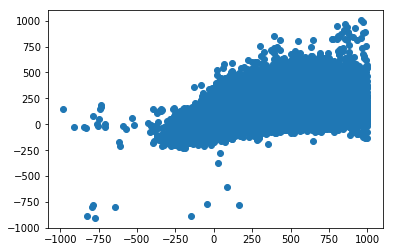

Pearson corr = (0.5844412334270302, 0.0)
0:	learn: 0.9932437	test: 0.9932425	best: 0.9932425 (0)	total: 90.7ms	remaining: 15m 6s
50:	learn: 0.6553695	test: 0.6553637	best: 0.6553637 (50)	total: 5.55s	remaining: 18m 3s
100:	learn: 0.3175032	test: 0.3174884	best: 0.3174884 (100)	total: 11.4s	remaining: 18m 39s
150:	learn: 0.0122902	test: 0.0120253	best: 0.0120253 (150)	total: 17.3s	remaining: 18m 48s
200:	learn: 0.0112896	test: 0.0108764	best: 0.0108764 (200)	total: 23.3s	remaining: 18m 54s
250:	learn: 0.0111406	test: 0.0107211	best: 0.0107211 (250)	total: 29.2s	remaining: 18m 55s
300:	learn: 0.0110240	test: 0.0106083	best: 0.0106083 (300)	total: 34.9s	remaining: 18m 45s
350:	learn: 0.0109403	test: 0.0105215	best: 0.0105215 (350)	total: 40.4s	remaining: 18m 30s
400:	learn: 0.0108799	test: 0.0104802	best: 0.0104793 (393)	total: 46s	remaining: 18m 22s
450:	learn: 0.0108218	test: 0.0104390	best: 0.0104373 (449)	total: 51.8s	remaining: 18m 16s
500:	learn: 0.0107791	test: 0.0104175	best: 0.01

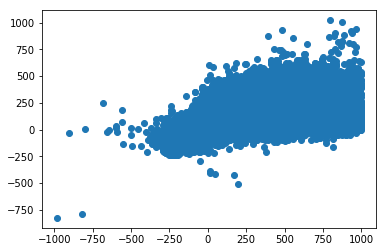

Pearson corr = (0.5850256185635485, 0.0)
0:	learn: 0.9932344	test: 0.9932363	best: 0.9932363 (0)	total: 92.6ms	remaining: 15m 26s
50:	learn: 0.6550954	test: 0.6550578	best: 0.6550578 (50)	total: 5.46s	remaining: 17m 44s
100:	learn: 0.3169334	test: 0.3168550	best: 0.3168550 (100)	total: 11.6s	remaining: 18m 56s
150:	learn: 0.0123934	test: 0.0120386	best: 0.0120386 (150)	total: 17.7s	remaining: 19m 14s
200:	learn: 0.0113501	test: 0.0108799	best: 0.0108799 (200)	total: 23.8s	remaining: 19m 20s
250:	learn: 0.0111567	test: 0.0106749	best: 0.0106749 (250)	total: 29.9s	remaining: 19m 22s
300:	learn: 0.0110383	test: 0.0105771	best: 0.0105771 (300)	total: 35.6s	remaining: 19m 6s
350:	learn: 0.0109667	test: 0.0105100	best: 0.0105100 (350)	total: 41.3s	remaining: 18m 54s
400:	learn: 0.0108998	test: 0.0104555	best: 0.0104555 (400)	total: 47.1s	remaining: 18m 46s
450:	learn: 0.0108385	test: 0.0103973	best: 0.0103973 (450)	total: 52.9s	remaining: 18m 41s
500:	learn: 0.0107854	test: 0.0103519	best: 0

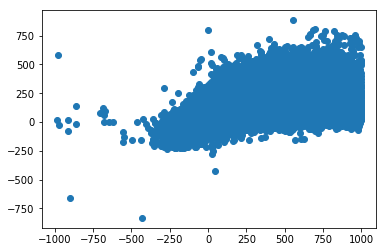

Pearson corr = (0.5871931123451952, 0.0)


In [0]:
def mape(y, y_hat):
  return np.mean(np.abs(y - y_hat) / np.maximum(1, np.abs(y)))

kf = KFold(n_splits=3, shuffle=True, random_state=42)

for train_idx, test_idx in kf.split(X, y):
  X_train = X.iloc[train_idx, :]
  X_test = X.iloc[test_idx, :]
  
  y_train = y.iloc[train_idx]
  y_test = y.iloc[test_idx]
    
  y_min = y_train.min()
  y_train = y_train - y_min + 2
  y_train = np.log(y_train)
  
  train_idx = np.random.choice(X_train.index, replace=False, 
                               size=int(0.95 * len(X_train)))
  val_idx = list(set(X_train.index) - set(train_idx))

  X_val = X_train.loc[val_idx, :]
  y_val = y_train.loc[val_idx]
  X_train = X_train.loc[train_idx, :]
  y_train = y_train.loc[train_idx]
  
  cat = CatBoostRegressor(iterations=10000, od_type='Iter', objective='MAPE',
                          od_wait=100, task_type='GPU', eval_metric='MAPE',
                          learning_rate=0.33)
  cat.fit(X_train, y_train, eval_set=(X_val, y_val), 
          verbose=50, 
          cat_features=cat_col_ix)
  
  preds = cat.predict(X_test)
  preds = np.exp(preds) - 2 + y_min
  
  print('MAE = {}'.format(mean_absolute_error(y_test, preds)))
  print('MAPE = {}'.format(mape(y_test.values, preds)))
  plt.figure()
  plt.scatter(y_test, preds)
  plt.show()
  print('Pearson corr = {}'.format(pearsonr(y_test, preds)))

In [0]:
cat.save_model(f'{DRIVE_PATH}/test_model.cbm')

In [0]:
print(y_min)

-984.0000000000001


# TODO:

* Bin the target domain into 3 categories (or the amount of reliablity scores), asymmetric around 0, and train a classifier

![](https://i.imgur.com/4smjmTY.png)

* Try to find some more features

* Play around with objective functions. MAPE works really well atm.

* Currently only using 1/70 million rows... Train on all data! Probably the code will need to be rewritten (calculate features on batches of data or using database queries to make the features, fiddle around with hyper-parameters of catboost to avoid memory error)

In [0]:
import pandas as pd
import numpy as np
import json
import re
import requests
import time
import pickle
from datetime import datetime
from catboost import CatBoostRegressor, Pool


before = time.time()
cat = CatBoostRegressor()
cat.load_model('test_model.cbm')
after = time.time()
# print(f'Loading model: {after-before} sec.')


stations_df = pd.read_csv('../data/stations.csv')
station_uris = json.load(open('../data/station_uris_irail.json', 'r'))
encoders = pickle.load(open('encoders.pickle', 'rb'))




def station_to_uri(station):
	try:
		return station_uris[station]
	except KeyError:
		return None


def get_seconds_since_midnight(datetime):
	midnight =  datetime.replace(hour=0, minute=0, second=0, microsecond=0)
	return (datetime - midnight).total_seconds()


def get_line_number(vehicle):
	# Expected input: "IC1515"
	pattern = re.compile("^([A-Z]+)([0-9]+)$")
	vehicle_type = pattern.match(vehicle).group(1)
	vehicle_nr = int(pattern.match(vehicle).group(2))
	line_nr = 0
	if vehicle_type == 'IC':
		line_nr = int(100 * np.floor(vehicle_nr / 100))
	elif vehicle_type == 'L':
		line_nr = int(50 * np.floor(vehicle_nr / 50))
	elif vehicle_type == 'S':
		line_nr = int(50 * np.floor(vehicle_nr / 50))
	else:
		line_nr = 'P'
	return vehicle_nr, line_nr


def encode(feature, value):
	return encoders[feature].transform([value])




def get_features(vehicle_id, time_str):
	parsed_time = pd.to_datetime(time_str, format='%d-%m-%Y %H:%M')
	parsed_time_str = parsed_time.strftime('%d%m%y')
	VEHICLE_URL = 'http://api.irail.be/vehicle/?id={}&date={}&format=json&lang=nl'.format(vehicle_id, parsed_time_str)

	line_id = vehicle_id.split('.')[-1]
	pattern = re.compile("^([A-Z]+)([0-9]+)$")
	train_type = pattern.match(line_id).group(1)
	# vehicle_nr, line = get_line_number(line_id)

	resp = requests.get(VEHICLE_URL)
	resp = json.loads(resp.content)
	uri_dep = resp['stops']['stop'][0]['stationinfo']['@id']  # Name of the departure station
	stop_dep = int(stations_df[stations_df['URI'] == uri_dep].iloc[0, :]['avg_stop_times'])
	station_dep = uri_dep.split('/')[-1]
	uri_arr = resp['stops']['stop'][-1]['stationinfo']['@id']
	stop_arr = int(stations_df[stations_df['URI'] == uri_arr].iloc[0, :]['avg_stop_times'])
	station_arr = uri_arr.split('/')[-1]
	line = f'{uri_dep}_{uri_arr}'

	delays = []
	for stop in resp['stops']['stop']:
		try:
			station_cur_uri = station_to_uri(stop['station'])
			station_cur = station_cur_uri.split('/')[-1]
			date = datetime.utcfromtimestamp(int(stop['time']))
			departure_time  = datetime.utcfromtimestamp(int(stop['scheduledDepartureTime']))
			arrival_time  = datetime.utcfromtimestamp(int(stop['scheduledArrivalTime']))
			dotw = date.weekday()
			weekend = dotw > 4
			month = date.month
			seconds_since_midnight = get_seconds_since_midnight(date)
			expected_time_station = (departure_time - arrival_time).total_seconds()

			station_info = stations_df[stations_df['URI'] == station_cur_uri].iloc[0, :]
			station_lng = station_info['longitude']
			station_lat = station_info['latitude']
			station_stop = station_info['avg_stop_times']

			stuff = [dotw, station_cur, line_id, train_type, station_arr, station_dep, line]
			encoded_features = ['dotw', 'station_cur', 'line_id', 'train_type', 'station_arr', 'station_dep', 'line']
			encoded = {}
			for value, feature in zip(stuff, encoded_features):
				print(feature, value)
				encoded[feature] = encoders[feature].transform([value])
				print(str(encoded[feature]) + '\n\n')

			vector = [encoded['station_cur'], encoded['station_dep'], encoded['station_arr'], encoded['dotw'], weekend, month, seconds_since_midnight, expected_time_station, station_lng, station_lat, station_stop, encoded['train_type'], encoded['line_id'],stop_arr, stop_dep, encoded['line']]

			print(f'CATBOOST: {cat.feature_names_}\n\n')
			print(f'VECTOR: {vector}\n\n')

			before = time.time()
			delay = cat.predict([vector])[0]
			# delay = np.exp(delay) - 2 + y_min  # TODO: Model is trained on logarithm!!
			after = time.time()
			# print(f'Prediction: {after-before} sec.')

			delays.append((stop['station'], stop['time'], delay))
		except Exception as e:
			raise e
			delays.append((stop['station'], stop['time'], np.NaN))
	return delays


print(get_features('BE.NMBS.IC1517', '11-07-2019 15:00'))

CatBoostError: ignored